In [1]:
import numpy as np
import os
import pandas as pd
import time
import math

# package for io 
from aicsimageio.writers import OmeTiffWriter
from aicsimageio.readers.ome_tiff_reader import OmeTiffReader

from CustomFunctions.track_functions import segment_caax_tracks_iSIM_visiview_halfsize
import itertools
from skimage import measure as skmeasure
import datetime

# load in some stuff to speed up processing
# (following https://sedeh.github.io/python-pandas-multiprocessing-workaround.html)
import multiprocessing

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)

        
# Function to find Angle
def angle_distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

In [6]:
############# get CAAX segmentations of whole images and macro-scale shape data #################
# some experiment details
ip = 0.1613 #um / pixel  #0.1613 40xW  #0.3226 20xW
step = 0.5 # um

# path to folder 
folder_fl = 'D:/Data/RandomWalkiSIM/Raw_Data/'
filelist_fl = [fl for fl in os.listdir(folder_fl) if '.stk' not in fl and '.nd' not in fl]

# u=0

for u in range(len(filelist_fl)):
    #get all the trans camera (CAAX) images
    imagelist = [fl for fl in os.listdir(folder_fl+filelist_fl[u]) if fl.endswith('.stk') and 'Trans' in fl]
    #sort by time point
    imagelist = sorted(imagelist, key=lambda x: int("".join([i for i in x if i.isdigit()])))
    results = []

    if __name__ ==  '__main__':
    # use multiprocessing to perform segmentation and x,y,z determination
        pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()-1)
        for t, im in enumerate(imagelist):
            imname = folder_fl + filelist_fl[u] + '/' + im
            pool.apply_async(segment_caax_tracks_iSIM_visiview_halfsize, args=(imname, ip, step, t, ), 
                             callback=collect_results)
        pool.close()
        pool.join()
        print(f'Finished segmenting {filelist_fl[u]}')
        


    #organize the semented frames into a segmented stack
    segmented_img = np.zeros((len(imagelist),
                             results[0][3][-3],
                             results[0][3][-2],
                             results[0][3][-1]))
    for r in results:
        fr = r[2]
        segmented_img[fr,:,:,:] = r[1]    

    #covert to more compact data type
    segmented_img = segmented_img.astype(np.uint8)

    #save the segmented image
    OmeTiffWriter.save(segmented_img,folder_fl + filelist_fl[u] + '/' + filelist_fl[u] + '_segmented.tiff', dim_order = "TZYX", overwrite_file=True)


    #save the skimage region props
    df = pd.DataFrame()
    for d in results:
        df = df.append(pd.DataFrame(d[0], columns = ['cell', 
                     'frame', 'z_min', 'y_min', 
                    'x_min','z_max', 'y_max', 'x_max',
                   'z', 'y', 'x', 'z_range',
                   'area', 'convex_area', 'extent',
                   'minor_axis_length', 'major_axis_length']))
    df = df.sort_values(by = ['frame','cell'])
    df.to_csv(folder_fl + filelist_fl[u] + '/' + filelist_fl[u] + '_region_props.csv')


Finished segmenting 20221116_488actin-GFP_646CAAXHalotag_2min1
Finished segmenting 20221116_488actin-GFP_646CAAXHalotag_2min2
Finished segmenting 20221116_488actin-GFP_646CAAXHalotag_2min3
Finished segmenting 20221116_488actin-GFP_646CAAXHalotag_2min4
Finished segmenting 20221116_488actin-GFP_646CAAXHalotag_2min5
Finished segmenting 20221116_488actin-GFP_646CAAXHalotag_2min6
Finished segmenting 20221121_405Hoechst_646CAAXHalotag_2min2
Finished segmenting 20221121_405Hoechst_646CAAXHalotag_2min3
Finished segmenting 20221121_405Hoechst_646CAAXHalotag_2min4
Finished segmenting 20221121_405Hoechst_646CAAXHalotag_2min5
Finished segmenting 20221121_405Hoechst_646CAAXHalotag_2min6


In [ ]:
############################# RUN TRACKMATE TRACKING ON SEGMENTED IMAGES ##################################

In [ ]:
#################### Determine Gradient Profile ####################
from skimage.filters import gaussian
from skimage.transform import rescale, resize


xyres = 0.1613 #um / pixel
zstep = 0.5 # um

#open gradient image
folder = 'F:/caged_FITC/20220831/'
files = os.listdir(folder)
img = skimage.io.imread(folder + files[0] + '/' + os.listdir(folder + files[0])[0])


size = (round(img.shape[-3]*zstep/xyres), img.shape[-1])
adj_zstep = img.shape[-3]*zstep/round(img.shape[-3]*zstep/xyres)
img_ex = np.zeros((img.shape[0],size[0], img.shape[-2], img.shape[-1]))

for t in range(img.shape[0]):
    for i in range(img.shape[-2]):
        img_ex[t,:,i,:] = resize(img[t,:,i,:], size, 1)


vec_arr = []
grid_arr = []
for i in range(img_ex.shape[0]):
    #smoothen image
    smooth = gaussian(img_ex[i,:,:,:], sigma = 50)
    #normalize image
    norm = smooth-smooth.min()
    norm = norm/norm.max()
    # #downscale image
    small = rescale(norm, 0.0625)
    #get derivative ie vectors of gradient
    dz, dy, dx = np.gradient(small)
    vec_arr.append(np.stack([dz, dy, dx]))
    
#get the positions that each vector would be in in the original larger image
xlin = np.linspace(0,img_ex.shape[-1],small.shape[-1])
ylin = np.linspace(0,img_ex.shape[-2],small.shape[-2])
zlin = np.linspace(0,img_ex.shape[-3],small.shape[-3])


#combine the vectors and grid positions for entire video
#dimension order is frame, vector or grid position [z,y,x], z, y, x
grad_vecs = np.stack([x for x in vec_arr])
grad_grid = pd.concat([pd.Series(zlin, name='z_index'),
           pd.Series(ylin, name='y_index'),
           pd.Series(xlin, name='x_index')], axis = 1)
    
#save gradient vectors
gradientfile = folder + files[0] + '/gradient_vectors.npy'
np.save(gradientfile, grad_vecs)

#save grid positions
gridpositions = folder + files[0] + '/grid_positions.csv'
grad_grid.to_csv(gridpositions)


In [1]:
############### SEGMENT AND SAVE CELLS ################################

############## alignment by chemical gradient ###################

from scipy.spatial import KDTree, distance
from itertools import groupby
from operator import itemgetter
from scipy import interpolate

from aicsimageio.readers.bioformats_reader import BioformatsReader

#import the cell segmentation and rotation function
# import sys
# # insert at 1, 0 is the script path (or '' in REPL)
# import_path = 'C:/Users/Aaron/Documents/PythonScripts/CustomFunctions'
# sys.path.insert(1, import_path)
from CustomFunctions.segment_cells_iSIM import segment_cells_rotafter_VV_chem

from CustomFunctions.persistance_activity import get_pa


# path to folder(s)
folder_fl = 'D:/Aaron/Data/Chemotaxis/Processed_Data/Combined_Images/'
filelist_fl = [f for f in os.listdir(folder_fl) if '.' not in f]
savedir = 'D:/Aaron/Data/Chemotaxis/Processed_Data/'
raw_dir = 'D:/Aaron/Data/Chemotaxis/Raw_Data/'
ind_dir = 'D:/Aaron/Data/Chemotaxis/Data_and_Figs/'


#parameters for segmentation
xy_buffer = 25 #pixels
z_buffer = 7 #pixels
sq_size = 250 #pixels
xyres = 0.1613 #um / pixel
zstep = 0.5 # um
norm_rot = 'widest'
interval = 15
intthresh = 120 #for the half shrunken images, determined by manually crossreferencing


for u in filelist_fl:

    ################## align trackmate data with region props data ################
    rpcsv = [x for x in os.listdir(folder_fl + filelist_fl[u]) if x.endswith("region_props.csv")][0]
    rp = pd.read_csv(folder_fl + filelist_fl[u] + '/' + rpcsv, index_col = 0)
    tmcsv = [x for x in os.listdir(folder_fl + filelist_fl[u]) if x.endswith("TrackMateLog.csv")][0]
    tm = pd.read_csv(folder_fl + filelist_fl[u] + '/' + tmcsv)
    #fix trackmate columns to get names right and units in microns
    tm['x'] = tm.POSITION_X*xyres
    tm['y'] = tm.POSITION_Y*xyres
    tm['z'] = tm.POSITION_Z*zstep
    #make kdtree and query with trackmate log
    kd = KDTree(rp[['frame','x','y','z']].to_numpy())
    dd, ii = kd.query(tm[['FRAME','x','y','z']])
    df_track = pd.concat([tm.drop(columns=['POSITION_X','POSITION_Y','POSITION_Z']), 
                        rp.iloc[ii].drop(columns=['frame','x','y','z', 'cell']).reset_index(drop=True)], axis=1)
    df_track = df_track.rename(columns={'TRACK_ID':'cell', 'FRAME':'frame'})
    #sort by cell and frame
    df_track = df_track.sort_values(['cell','frame'])




    # #read in image and tracking data
    image_name = u
    direct = folder_fl+u+'/'
    test = [x for x in os.listdir(direct+'/') if '.tif' in x][0]
    # currentim = folder_fl+filelist_fl[u]+'/'+ filelist_fl[u] + '_MMStack_Pos0.ome.tif'
    currentim = direct+'/'+ test
    im_temp_whole = tiff_reader.TiffReader(currentim)
    #double shape because it was halved
    imshape = [2*x for x in im_temp_whole.shape[1:]]





    #############find distance travelled##################
    longdistmatrix = distance.pdist(df_track[['x','y','z']])
    shortdistmatrix = distance.squareform(longdistmatrix)
    shortdistmatrix = np.array(shortdistmatrix)
    dist = pd.Series([], dtype = 'float64')
    for count, i in enumerate(shortdistmatrix):
        if count == 0:
            temp = pd.Series([0])
            dist = dist.append(temp, ignore_index=True)
        else:
            temp = pd.Series(shortdistmatrix[count,count-1])
            dist = dist.append(temp, ignore_index=True)
    df_track = df_track.reset_index(drop = True)
    df_track['dist'] = dist
    #first rows that have super long distances from previous cell, so set them to 0
    df_track.loc[df_track.groupby('cell').head(1).index,'dist'] = 0

    ############ replace unrealistic jumps in distance ##############
    for x in df_track[df_track.dist>4].index.values:
        df_track['dist'][x] = df_track.dist.mean()

    ############## find euclidean distance #############
    euclid = pd.DataFrame([])
    for i, cell in df_track.groupby('cell'):
        FL = cell.iloc[[0,-1]]
        euc_dist = distance.pdist(FL[['x','y','z']])
        euclid = euclid.append({'cell':cell.cell.iloc[0], 'euc_dist':euc_dist[0]}, ignore_index = True)
    cellsmorethan = euclid.loc[euclid['euc_dist']>5, 'cell']
    df_track = df_track[df_track.cell.isin(cellsmorethan)]

    #     ########remove "slow"/dead cells############
    #     #sum distances
    #     df_track_distsums = df_track.groupby('cell').sum()
    #     df_track_distsums = df_track_distsums.add_suffix('_sum').reset_index()

    #     #grab only cells with sums above a threshold distance
    #     cellsmorethan = df_track_distsums.loc[df_track_distsums['dist_sum']>5, 'cell']
    #     df_track = df_track[df_track.cell.isin(cellsmorethan)]

    
    ##########remove small things that are likely dead cells or parts of cells###########
    df_track = df_track[df_track['area'] > 15000 ]
    ######### remove cells with low caax intensity ###########
    df_track = df_track[df_track['intensity_avg'] > 120 ]
    #reset index after dropping all the rows
    df_track = df_track.reset_index(drop = True)
    
    ########remove edge cells############
    #only grab rows that aren't zero in z_min
    df_track = df_track.loc[df_track['x_min'] >5 ]
    df_track = df_track.loc[df_track['y_min'] >5 ]
    df_track = df_track.loc[df_track['z_min'] !=0 ]
    #remove rows where z_max matches z_range
    df_track = df_track.loc[df_track['x_max'] != im_temp_whole.shape[-1]-4]
    df_track = df_track.loc[df_track['y_max'] != im_temp_whole.shape[-2]-4]
    df_track = df_track.loc[df_track['z_max'] != (df_track['z_range']-1)]
    #reset index after dropping all the rows
    df_track = df_track.reset_index(drop = True)




    ######## remove cells that touch ###########    
    to_remove = []
    for i, cell in df_track.groupby('cell'):
        if i>0:
            changes = abs(cell['convex_area'].pct_change())
            largerthan = changes[changes>0.75]
            if largerthan.empty == False:
                to_remove.extend(largerthan.index.to_list())


            # changes = cell['convex_area'].diff()
            # largerthan = changes[changes>cell['convex_area']*0.333]
            # smallerthan = changes[changes<cell['convex_area']*-0.333]
            # print(largerthan.index,smallerthan.index)
            # #remove all frames of a cell after it contacts another cell
            # if largerthan.empty == False:
            #     for n in largerthan.index:
            #         to_remove.append(list(range(n, max(cell.index)+1)))
            # #remove all frames of a cell before it splits from another cell
            # if smallerthan.empty == False:
            #     for n in smallerthan.index:
            #         to_remove.append(list(range(cell.index[0], n-1)))
    # #remove duplicate indicies
    # to_remove = [j for x in to_remove for j in x]
    # to_remove = list(set(to_remove))
    #drop touching or splitting cells
    df_track = df_track.drop(to_remove)



    #######get cells with at least three consecutive frames##########
    if df_track.empty == False:
        for i, cells in df_track.groupby('cell'):
            cells = cells.reset_index(drop = True)
            runs = list()
            #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
            for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                currentrun = list(map(itemgetter(1), g))
                list.append(runs, currentrun)
                
            for r in runs:
                r = np.array(r, dtype=int)
                #skip runs less than 3 frames long
                if len(r)<3:
                    pass
                else:
                    cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]


                #segment the cell channel and get centroid
                df = pd.DataFrame()
                if __name__ ==  '__main__':
                    # use multiprocessing to perform segmentation and x,y,z determination
                    pool = multiprocessing.Pool(processes=60)
                    results = []
                    for t, row in cell.iterrows():

                        xmincrop = int(max(0, row.x_min-xy_buffer))
                        ymincrop = int(max(0, row.y_min-xy_buffer))
                        zmincrop = int(max(0, row.z_min-z_buffer))


                        zmaxcrop = int(min(row.z_max+z_buffer, im_temp_whole.shape[-3])+1)
                        ymaxcrop = int(min(row.y_max+xy_buffer, im_temp_whole.shape[-2])+1)
                        xmaxcrop = int(min(row.x_max+xy_buffer, im_temp_whole.shape[-1])+1)

                        pool.apply_async(segment_cells_rotafter_VV_chem, args = (
                            raw_dir,
                            ind_dir,
                            row,
                            image_name,
                            savedir,
                            xyres,
                            zstep,
                            xmincrop, 
                            ymincrop, 
                            zmincrop,
                            xmaxcrop, 
                            ymaxcrop, 
                            zmaxcrop,
                            ),             
                            callback = collect_results)

                    pool.close()
                    pool.join()

                    print(f'Done segmenting {image_name} cell {cell.cell.iloc[0]}')

            if any([x == None for x in results]):
                ind = results.index(None)
                if len(results[:ind])<3:
                    pass
                else:
                    results = results[:ind]

            #aggregate the dataframe
            for d in results:
                df = df.append(pd.DataFrame(d, columns = d.keys(), index=[0]))
            df = df.sort_values(by = 'frame').reset_index(drop=True)

            #make sure there are no gaps due to failed segmentations
            if any(df.frame.diff()>1):
                dft = df.reset_index(drop = True)
                runs = list()
                #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
                for k, g in groupby(enumerate(dft['frame']), lambda ix: ix[0] - ix[1]):
                    currentrun = list(map(itemgetter(1), g))
                    list.append(runs, currentrun)
                whichframes = np.array(max(runs, key=len), dtype=int)
                pullrows = [dft[dft['frame']==i].index[0] for i in whichframes]
                df = dft.iloc[pullrows].reset_index(drop=True)
            else:
                pass
            
            
            #add new distances from cropped image
            #############find distance travelled##################
            longdistmatrix = distance.pdist(df[['x','y','z']])
            shortdistmatrix = distance.squareform(longdistmatrix)
            shortdistmatrix = np.array(shortdistmatrix)
            dist = pd.Series([], dtype = 'float64')
            for count, i in enumerate(shortdistmatrix):
                if count == 0:
                    tmp = pd.Series([0])
                    dist = dist.append(tmp, ignore_index=True)
                else:
                    tmp = pd.Series(shortdistmatrix[count,count-1])
                    dist = dist.append(tmp, ignore_index=True)
            df['dist'] = dist



            ############## Bayesian persistence and activity #################
            persistence, activity, speed = get_pa(df, interval)
            df['persistence'] = np.concatenate([np.array([np.nan]*2), persistence])
            df['activity'] = np.concatenate([np.array([np.nan]*2), activity])
            df['speed'] = np.concatenate([np.array([np.nan]), speed])
            df['avg_persistence'] = np.array([persistence.mean()]*(len(persistence)+2))
            df['avg_activity'] = np.array([activity.mean()]*(len(activity)+2))
            df['avg_speed'] = np.array([speed.mean()]*(len(speed)+1))


            # ############# SEGMENT THE NUCLEUS ####################
            # seg_nucleus = np.zeros(temp_im[:,1,:,:,:].shape).astype(bool)
            # for t in range(temp_im.shape[0]):

            #set the k order for interpolation to the max possible
            if len(df)<6:
                kay = len(df)-1
            else:
                kay = 5

            #     seg_nucleus[t,:,:,:] = segment_nucleus(temp_im[t,1,:,:,:])
            pos = df[['x','y','z']]
            if bool(pos[pos.duplicated()].index.tolist()):
                ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                # if there is duplicate positions
                dups = pos[pos.duplicated()].index.tolist()
                pos_drop = pos.drop(dups, axis = 0)
                if pos_drop.shape[0]<3:
                    traj = np.zeros([1,2,3])
                else:
                    #get trajectories without the duplicates
                    tck, u = interpolate.splprep(pos_drop.to_numpy().T, k=kay)
                    yderv = interpolate.splev(u,tck,der=1)
                    traj = np.vstack(yderv).T
                    #re-insert duplicate row that was dropped
                    for d, dd in enumerate(dups):
                        traj = np.insert(traj, dd, traj[dd-1,:], axis=0)

            else:
                ######### FIND CELL TRAJECTORY AND EULER ANGLES ################
                #no duplicate positions
                #interpolate and get tangent at midpoint
                tck, u = interpolate.splprep(pos.to_numpy().T, k=kay)
                yderv = interpolate.splev(u,tck,der=1)
                traj = np.vstack(yderv).T

            #get the trajectory and the previous trajectory for each frame and 
            #save as an individual dataframe for each cell and frame
            for v, row in df.iterrows():
                row = df.loc[v]
                if v==0:
                    row['Prev_Trajectory_X'] = np.nan
                    row['Prev_Trajectory_Y'] = np.nan
                    row['Prev_Trajectory_Z'] = np.nan
                    row['Trajectory_X'] = traj[v,0]
                    row['Trajectory_Y'] = traj[v,1]
                    row['Trajectory_Z'] = traj[v,2]
                    row['Turn_Angle'] = np.nan
                    pd.DataFrame(row.to_dict(),index=[0]).to_csv(savedir + row.cell + '_cell_info.csv')
                if v>0:
                    row['Prev_Trajectory_X'] = traj[v-1,0]
                    row['Prev_Trajectory_Y'] = traj[v-1,1]
                    row['Prev_Trajectory_Z'] = traj[v-1,2]
                    row['Trajectory_X'] = traj[v,0]
                    row['Trajectory_Y'] = traj[v,1]
                    row['Trajectory_Z'] = traj[v,2]
                    row['Turn_Angle'] = angle_distance(traj[v-1,0], traj[v-1,1], traj[v-1,2], traj[v,0], traj[v,1], traj[v,2])
                    pd.DataFrame(row.to_dict(),index=[0]).to_csv(savedir + row.cell + '_cell_info.csv')

NameError: name 'os' is not defined

In [5]:
from CustomFunctions import shparam_mod


savedir = 'D:/Aaron/Data/Chemotaxis/Processed_Data/'


#make savedir if it doesn't exist
datadir = 'D:/Aaron/Data/Chemotaxis/Data_and_Figs/'
if not os.path.exists(datadir):
    os.makedirs(datadir)
pilrf = savedir+'PILRs/'
if not os.path.exists(pilrf):
    os.makedirs(pilrf)
    
    
xyres = 0.1613 #um / pixel
zstep = 0.16097560975609757 # um
align_method = 'trajectory'
norm_rot = 'widest weighted'
l_order = 10
nisos = [1,63]
sigma = 0
errorlist = []


#get all segmented images
imlist = [x for x in os.listdir(savedir) if x.endswith('segmented.tiff')]

start = 0
stop = 300
allresults = []
while stop<len(imlist):

    if __name__ ==  '__main__':
        results = []
        pool = multiprocessing.Pool(processes=60)
        for i in imlist[start:stop]:
            #get path to segmented image
            impath = savedir + i
            if 'actin' in impath:
                str_name = 'actin'
            elif 'Hoechst' in impath:
                str_name = 'nucleus'
            elif 'myosin' in impath:
                str_name = 'myosin'
            elif 'DNA' in impath:
                str_name = 'nucleus'

        #put in the pool
        pool.apply_async(shparam_mod.shcoeffs_and_PILR_nonuc, args = (
                impath,
                savedir,
                xyres,
                zstep,
                str_name,
                errorlist,
                norm_rot,
                l_order,
                nisos,
                sigma,
                align_method,
                ),
                callback = collect_results)

        pool.close()
        pool.join()

    allresults.extend(results)

    start = stop + 1
    stop = stop + 1000
    if stop>len(imlist):
        stop = len(imlist)         

errorlist = []
bigdf = pd.DataFrame()

for r in results:
    

    Shape_Stats = pd.DataFrame([r[0].values()],
                                  columns = list(r[0].keys()))
    cell_coeffs = pd.DataFrame([r[1].values()],
                               columns = list(r[1].keys()))

    bigdf = bigdf.append(pd.concat([Shape_Stats,cell_coeffs], axis=1))

    errorlist.extend(r[2])


#save the shape metrics dataframe
bigdf = bigdf.set_index('cell')
bigdf.to_csv(datadir + 'Shape_Metrics.csv')

#save list of cells that don't have centroid in shape
pd.Series(errorlist).to_csv(datadir + 'ListToExclude.csv')    

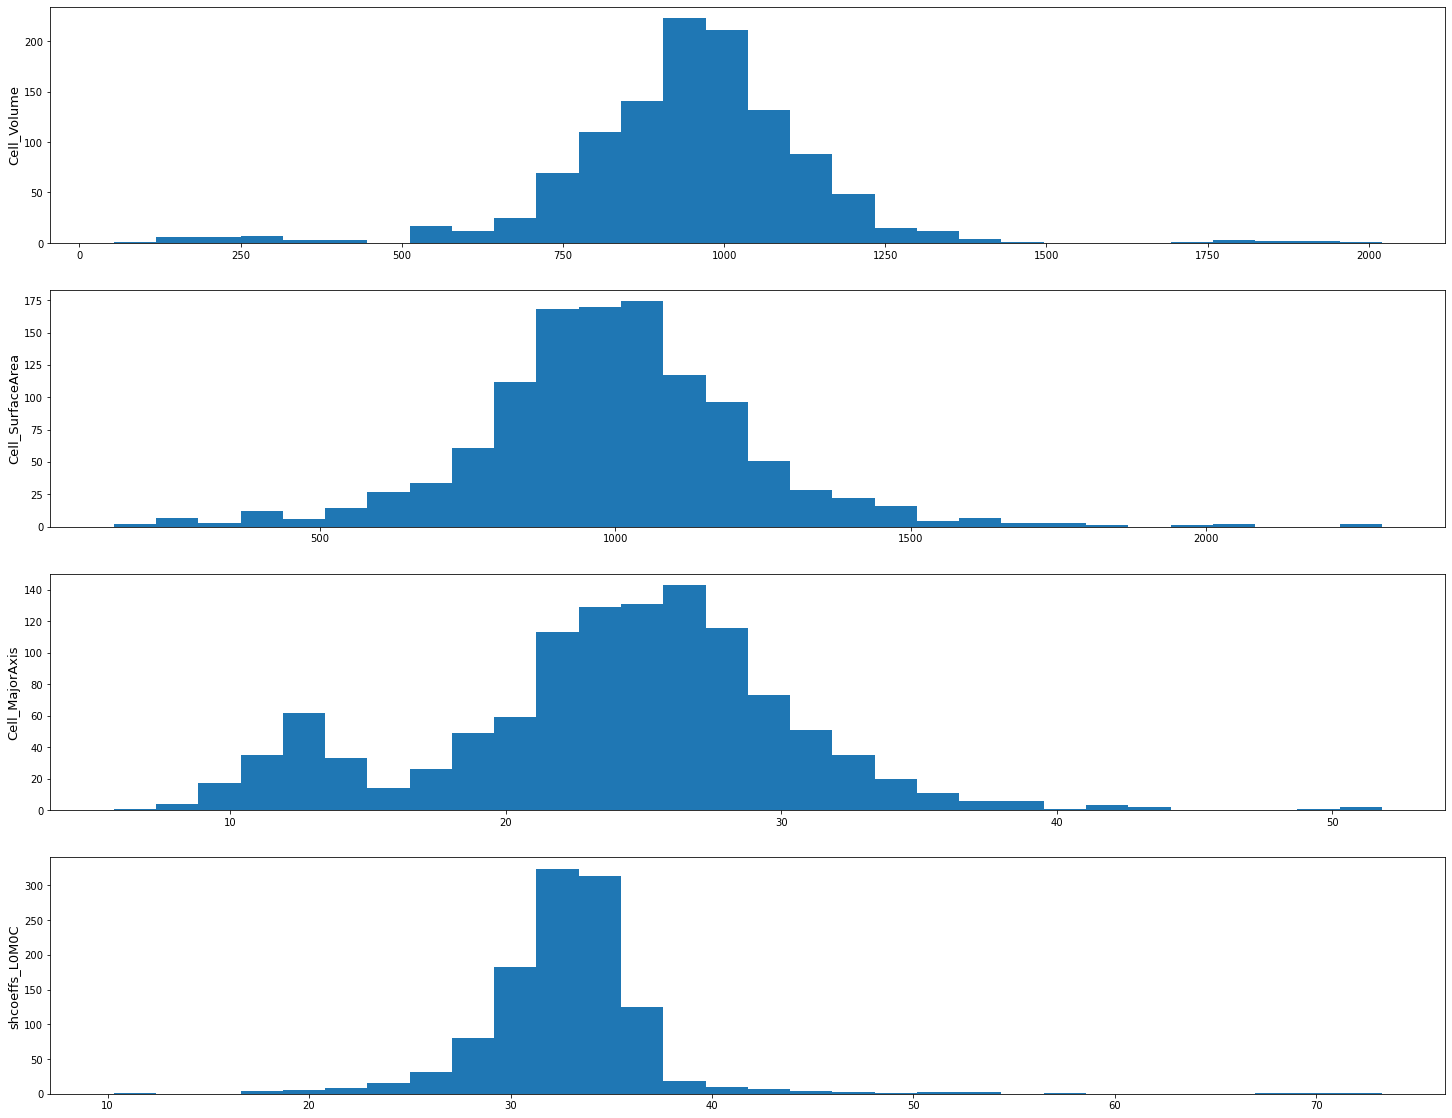

In [2]:
import matplotlib.pyplot as plt

#################### Check shape distributions for extreme outliers before PCA ####################

folder_fl = 'D:/Aaron/Data/Chemotaxis/'
data_fl = folder_fl + 'Data_and_Figs/'
#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics.csv', index_col='cell')

# df.shcoeffs_L0M0C
metrics = ['Cell_Volume','Cell_SurfaceArea','Cell_MajorAxis','shcoeffs_L0M0C']
df = df[(df.Cell_Volume < 1850) & (df.Cell_Volume > 725)]
df = df[df.Cell_SurfaceArea < 1750]
fig, axes = plt.subplots(4, 1, figsize=(25,20))#, sharex=True)
for i, ax in enumerate(axes):
    ax.hist(abs(df[metrics[i]]), 30) #, 30, (-2,2))
    ax.set_ylabel(metrics[i], fontsize = 13)
#volume threshold determined by looking through cropped cell images
newdf = df[(df.Cell_Volume < 1850) & (df.Cell_Volume > 725)].copy()
newdf = newdf[newdf.Cell_SurfaceArea < 1750]
    
# newdf = df[df.Cell_Volume < 5000]
# newdf = newdf[newdf.Nucleus_Volume < 1000]
# newdf = newdf[newdf.Nucleus_Volume > 100]
# newdf = newdf[newdf.Nucleus_SurfaceArea < 400]
newdf.to_csv(data_fl + 'Shape_Metrics_outliersremoved.csv')

In [32]:
df.Cell_Volume.sort_values(ascending=False).head(20)

cell
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_4_frame_6                    1926.389048
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_24_frame_10    1846.320178
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_24_frame_9     1808.319467
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_24_frame_11    1808.108314
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_4_frame_5                    1775.973025
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_24_frame_12    1739.996271
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_5_frame_2                    1410.629401
20221116_488actin-GFP_646CAAXHalotag_2min6_cell_2_frame_4                    1360.252520
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_23_frame_19    1354.990031
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_5_frame_3                    1344.425262
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_23_frame_18    1337.337586
20221116_488acti

In [3]:
######### Perform PCA and divide cells into shape space bins ################

#import stuff and define functions
from typing import Dict, List, Optional, Union
from pathlib import Path
from sklearn.decomposition import IncrementalPCA, PCA
from CustomFunctions import shapePCAtools
import math
from vtk.util import numpy_support
import vtk
from aicsshparam import shtools

folder_fl = 'D:/Aaron/Data/Chemotaxis/'
data_fl = folder_fl + 'Data_and_Figs/'
info_fl = folder_fl + 'Processed_Data/'

#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
lmax = 10

#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics.csv', index_col='cell')


#exclude cells with centroids outside the mesh
excludes = pd.read_csv(data_fl + 'ListToExclude.csv', index_col=0)
exlist = [i.replace('_segmented.tiff', '') for i in excludes.iloc[:,0].to_list()]
df = df.loc[[x for x in df.index if x not in exlist]]
coeff_df = df[[x for x in df.columns.to_list() if 'shcoeffs' in x]]


#add all of the other metrics from the single csv files
cellinfo = pd.DataFrame()
for i in df.index.to_list():
    tc = pd.read_csv(info_fl + i +'_cell_info.csv', index_col = 0)
    cellinfo = cellinfo.append(tc.loc[0])
# Add distance travelled per framerate to total frame
cellinfo.index = cellinfo.cell
df = df.merge(cellinfo.drop(columns=['image', 'x', 'y', 'z', 'cropx (pixels)',
       'cropy (pixels)', 'cropz (pixels)']), left_index = True, right_index = True)


# Fit and transform the data
pca = PCA(n_components=npcs)
pca = pca.fit(coeff_df)
matrix_of_features_transform = pca.transform(coeff_df)


# Dataframe of transformed variable
pc_names = [f"Cell_PC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = coeff_df.index)


# Adjust the sign of PCs so that larger cells are represent by positive values
#need actual volume data to do this so needs to be combined with shape metrics
df_trans['Cell_Volume'] = df.Cell_Volume
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(df_trans.Cell_Volume.values, df_trans[pc_name].values)
    if pearson[0, 1] < 0:
        df_trans[pc_name] *= -1
        pca.components_[pcid] *= -1

df_trans = df_trans.drop(columns = 'Cell_Volume')



################ RECONSTRUCT CELLS AT CERTAIN POINTS IN THE "SHAPE SPACE" ##################

df_dig = pd.DataFrame(index = df_trans.index)
for count, col in enumerate(df_trans.columns.to_list()):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = df_trans,
        feature = col,
        nbins = nbins,
        filter_based_on = df_trans.columns.to_list(),
        filter_extremes_pct = float(1),
        save = None,
        return_freqs_per_structs = False
    )
    #put bin_indexes into a larger list that I can later iterate through
    df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
    df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})

    
mid = math.ceil(nbins/2)
recon_PCs = np.zeros((npcs, nbins, npcs))
for pi, p in enumerate(pc_names):
    for c in range(nbins):
        for ni, n in enumerate(pc_names):
            if n == p:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==c+1].loc[:,n].mean()
            else:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==mid].loc[:,n].mean()

#get inverse pca transform of those values
recon_schoeffs = np.zeros((npcs, nbins, len(coeff_df.columns)))
for o in range(recon_schoeffs.shape[0]):
    for t in range(recon_schoeffs.shape[1]):
            recon_schoeffs[o,t,:] = pca.inverse_transform(recon_PCs[o,t,:])
            
    
#combine metrics and digitized pcs
df_dig = df.merge(df_dig, left_index = True, right_index = True)
#save
df_dig.to_csv(data_fl+"Shape_Metrics_with_Digitized_PCs.csv")


########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################

meshes = {}
aliases = ['Cell']

for pi, p in enumerate(pc_names):
    meshes[p] = {}
    for c in range(nbins):
        meshes[p][bins[c]] = {}
        row = pd.Series(recon_schoeffs[pi,c,:], index = coeff_df.columns.to_list())
        for i, a in enumerate(aliases):
            mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
            meshes[p][bins[c]][a] = mesh

                
                
################## save PC meshes ##################
savedir = folder_fl + 'PC_Meshes/'
if not os.path.exists(savedir):
    os.makedirs(savedir)
for p in list(meshes):
    for n, b in enumerate(list(meshes[p])):
        for a in list(meshes[p][b]):
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(savedir+p+'_'+str(b)+'_'+a+'.vtp')
            writer.SetInputData(meshes[p][b][a])
            writer.Write()



In [ ]:
   ...: df_dig.to_csv(data_fl+"Shape_Metrics_with_Digitized_PCs.csv")
   ...:
   ...:
   ...: ########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################
   ...:
   ...: meshes = {}
   ...: aliases = ['Cell']
   ...:
   ...: for pi, p in enumerate(pc_names):
   ...:     meshes[p] = {}
   ...:     for c in range(nbins):
   ...:         meshes[p][bins[c]] = {}
   ...:         row = pd.Series(recon_schoeffs[pi,c,:], index = coeff_df.columns.to_list())
   ...:         for i, a in enumerate(aliases):
   ...:             mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
   ...:             meshes[p][bins[c]][a] = mesh
   ...:
   ...:
   ...:
   ...: ################## save PC meshes ##################
   ...: savedir = folder_fl + 'PC_Meshes/'
   ...: if not os.path.exists(savedir):
   ...:     os.makedirs(savedir)
   ...: for p in list(meshes):
   ...:     for n, b in enumerate(list(meshes[p])):
   ...:         for a in list(meshes[p][b]):
   ...:             writer = vtk.vtkXMLPolyDataWriter()
   ...:             writer.SetFileName(savedir+p+'_'+str(b)+'_'+a+'.vtp')
   ...:             writer.SetInputData(meshes[p][b][a])
   ...:             writer.Write()

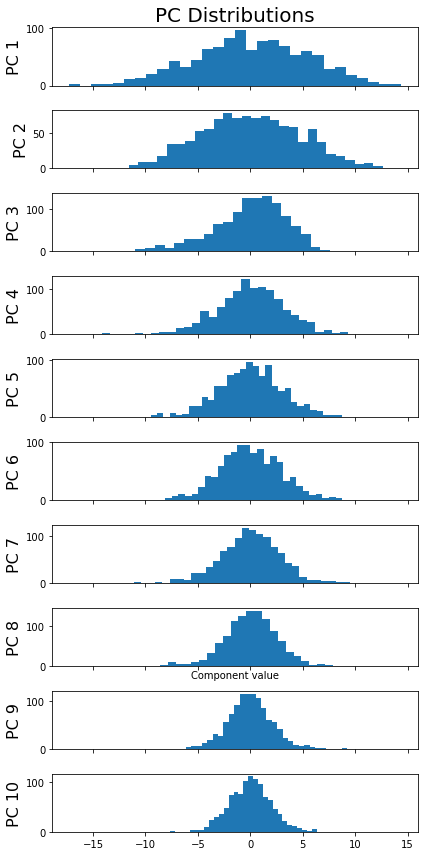

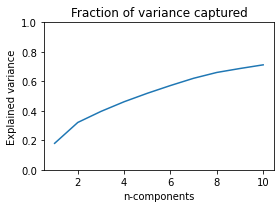

In [4]:
folder_fl = 'D:/Data/RandomWalkiSIM/Data/'
data_fl = folder_fl + 'Data_and_Figs/'

########### plot distributions of PCs ###################
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(df_trans.iloc[:,i].values, 30)
# for i, ax in enumerate(axes[:,1]):
#     ax.hist(nuc_weights[:,i], 30, (-2,2))
    
axes[0].set_title("PC Distributions", fontsize = 20)
# axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
[ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
axes[7].set_xlabel("Component value")

plt.tight_layout()
plt.savefig(data_fl+ 'PC distributions.png', bbox_inches='tight')



# How much variance is explained?
cell_variance = np.cumsum(pca.explained_variance_ratio_)
component_number = np.arange(len(cell_variance)) + 1

# Analysis of explained variance
df_dimred = {}
loading = pca.components_.T * np.sqrt(pca.explained_variance_)
for comp, pc_name in enumerate(pc_names):
    load = loading[:, comp]
    pc = [v for v in load]
    apc = [v for v in np.abs(load)]
    total = np.sum(apc)
    cpc = [100 * v / total for v in apc]
    df_dimred[pc_name] = pc
    df_dimred[pc_name.replace("_PC", "_aPC")] = apc
    df_dimred[pc_name.replace("_PC", "_cPC")] = cpc

# Store results as a dataframe
df_dimred["features"] = coeff_df.columns
df_dimred = pd.DataFrame(df_dimred)
df_dimred = df_dimred.set_index("features", drop=True)

# Plot variance
plt.figure(figsize=(4, 3))
plt.plot(component_number, cell_variance)
plt.ylim(0,1)
plt.xlabel("n-components")
plt.ylabel("Explained variance")
plt.title("Fraction of variance captured")

plt.tight_layout()
plt.savefig(data_fl + 'Variance captured.png', bbox_inches='tight')



# ######## OR A DIFFERENT PLOT ##############
# # Make plot of explained variance
# plt.plot(100 * pca.explained_variance_ratio_[:npcs_to_calc], "-o")
# title = "Cum. variance: (1+2) = {0}%, Total = {1}%".format(
#     int(100 * pca.explained_variance_ratio_[:2].sum()),
#     int(100 * pca.explained_variance_ratio_[:].sum()),
# )
# plt.xlabel("Component", fontsize=18)
# plt.ylabel("Explained variance (%)", fontsize=18)
# plt.xticks(
#     ticks=np.arange(npcs_to_calc),
#     labels=np.arange(1, 1 + npcs_to_calc),
#     fontsize=14,
# )
# plt.yticks(fontsize=14)
# plt.title(title, fontsize=18)
# plt.tight_layout()



############## SEE WHICH FEATURES ARE MOST IMPORTANT IN EACH PC #############
save = data_fl + 'Feature_Importance'
# Log feature importance along each PC
with open(f"{save}.txt", "w") as flog:

    for comp in range(npcs):

        print(
            f"\nExamplined variance by PC{comp+1} = {100*pca.explained_variance_ratio_[comp]:.1f}%",
            file=flog,
        )

        # Feature importance is reported in 3 ways:
        # _PC - raw loading
        # _aPC - absolute loading
        # _cPC - normalized cummulative loading
        pc_name = pc_names[comp]
        df_sorted = df_dimred.sort_values(
            by=[pc_name.replace("_PC", "_aPC")], ascending=False
        )
        pca_cum_contrib = np.cumsum(
            df_sorted[pc_name.replace("_PC", "_aPC")].values
            / df_sorted[pc_name.replace("_PC", "_aPC")].sum()
        )
        pca_cum_thresh = np.abs(pca_cum_contrib - 0.80).argmin()
        df_sorted = df_sorted.head(n=pca_cum_thresh + 1)

        print(
            df_sorted[
                [
                    pc_name,
                    pc_name.replace("_PC", "_aPC"),
                    pc_name.replace("_PC", "_cPC"),
                ]
            ].head(),
            file=flog,
        )

In [61]:
############## Average PILRs split by Genotype #########################

from CustomFunctions import PILRagg
from aicscytoparam import cytoparam
import re
import vtk

folder_fl = 'D:/Data/RandomWalkiSIM/Data/'
data_fl = folder_fl + 'Data_and_Figs/'
pilr_fl = folder_fl + 'PILRs/'
pilragg_fl = folder_fl + 'avgPILRs/'
if not os.path.exists(pilragg_fl):
    os.makedirs(pilragg_fl)
    
#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
nisos = [1,63]
lmax = 16

#make tiny sphere for inner mesh
#create inner sphere
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(0.0, 0.0, 0.0)
sphereSource.SetRadius(nisos[0]/2)
# Make the surface smooth.
sphereSource.SetPhiResolution(100)
sphereSource.SetThetaResolution(100)
sphereSource.Update()
spherepoly = sphereSource.GetOutput()




#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics_with_Digitized_PCs.csv', index_col='cell')


strr = ['actin','Hoechst']
str_list = []
for x in df.index.to_list(): 
    str_list.extend([g for g in strr if g in x])
df['Structure'] = str_list


pcdf = df[[x for x in df.columns.to_list() if 'bins' in x]]
for g in df.Structure.unique():
    for i, p in enumerate(pcdf.columns.to_list()):
        for b in bins:
            temp = pcdf[p][df.Structure==g]
            num = temp[temp==b].index.to_list()
            aggl = []
            for n in num:
                print(n)
                aggl.append(PILRagg.read_parameterized_intensity(pilr_fl + n))
            pagg = np.array(aggl)
            #get average representation
            pagg_avg = np.mean(pagg, axis = 0)
            #normalize representations
            pagg_norm = PILRagg.normalize_representations(pagg)
            pagg_norm_avg = np.mean(pagg_norm, axis = 0)
            dims = [['X', 'Y', 'Z', 'C', 'T'][d] for d in range(pagg_avg.ndim)]
            dims = ''.join(dims[::-1])
            OmeTiffWriter.save(pagg_avg, pilragg_fl+p[:-1]+str(b)+f'_{g}_repsagg.tif', dim_order=dims)
            OmeTiffWriter.save(pagg_norm_avg, pilragg_fl+p[:-1]+str(b)+f'_{g}_repsagg_norm.tif', dim_order=dims)


            mesh_outer = PILRagg.read_vtk_polydata(folder_fl+'PC_Meshes/'+f'Cell_PC{i+1}_{b}_Cell.vtp')
            domain, origin = cytoparam.voxelize_meshes([mesh_outer, spherepoly])
            coords_param, _ = cytoparam.parameterize_image_coordinates(
                seg_mem=(domain>0).astype(np.uint8),
                seg_nuc=(domain>1).astype(np.uint8),
                lmax=lmax,
                nisos=nisos
            )

            morphed = cytoparam.morph_representation_on_shape(
                        img=domain,
                        param_img_coords=coords_param,
                        representation=pagg_avg)
            morphed = np.stack([domain, morphed])
            OmeTiffWriter.save(morphed, pilragg_fl+p[:-1]+str(b)+f'_{g}_aggmorph.tif', dim_order='CZYX')

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_25_frame_10
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_4_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_12_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_2_frame_4
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_19_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_20_frame_8
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_3_frame_7
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_9_frame_11
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min2_cell_11_frame_1
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_18_frame_13
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_11_frame_1
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_12_frame_18
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_11_frame_2
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_13_frame_2
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_20_frame_19
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_21_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_22_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_2_frame_9
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_14_frame_11
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_14_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_14_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_14
20221114_488actin-GFP_646CAAXHalotag_20laser_10

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_12
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_16
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_21_frame_2
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_25_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_14
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_1
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_12_frame_1
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_12_frame_4
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_12_frame_2
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_12
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_12_frame_6
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_7
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_4_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min4_cell_16_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min5_cell_25_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min5_cell_30_frame_12
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_2_frame_9
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_14_frame_10
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_14_frame_11
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_13
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_17


20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_18
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_20
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_9
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_5_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_5_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_5_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_16_frame_3
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_19_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_19_frame_16
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_20_frame_13
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_20_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_21_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2m

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_12_frame_2
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_14
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_19
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_5_frame_3
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_5_frame_4
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_16_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_19_frame_17
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_20_frame_10
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_20_frame_11
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_20_frame_9
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_9_frame_2
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_9_frame_5
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_25_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_2_frame_2
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_12_frame_1
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_12_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_38_frame_17
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_5_frame_2
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_19_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_20_frame_10
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min2_cell_11_frame_3
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min2_cell_35_frame_19
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min2_cell_35_frame_20
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_17_frame_15
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_17_frame_17
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_17_frame_8
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_18_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_18_frame_16
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_18_frame_15
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_18_frame_11
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_18_frame_13
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_15
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_17
20221115_488actin-GFP_646CAAXHalotag_20l

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_16
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_18
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_7_frame_18
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_14
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_2
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_10
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_5
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_0_frame_4
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_11
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_15
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_17
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_18
20221115_488actin-GFP_646CAAXHalotag_20laser_10

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_2_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_38_frame_19
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_5_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_19_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_23_frame_20
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_9_frame_6
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_3_frame_5
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_3_frame_7
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min2_cell_16_frame_15
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min2_cell_23_frame_10
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_17_frame_19
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_20
20221115_488actin-GFP_646CAAXHalotag_20laser_100m

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_18_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_18_frame_11
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_15
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_16
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_17
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_18
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_2_frame_1
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_2_frame_2
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_12_frame_7
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_12_frame_6
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_10
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_11
20221115_488actin-GFP_646CAAXHalotag_20laser_10

20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_8
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_3_frame_3
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_8_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_8_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_8_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_13
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_13
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_3
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_4
2022

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_22_frame_16
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_12_frame_5
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_12_frame_6
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_2
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_4
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_0_frame_6
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_11
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_19
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_14_frame_8
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_4_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_4_frame_14
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_8_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_fr

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_12_frame_4
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_12_frame_7
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_10
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_11
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_14
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_11
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_0_frame_4
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_0_frame_5
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_15
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_16
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_17
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_18
20221115_488actin-GFP_646CAAXHalotag_20laser_100m

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_13
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_8_frame_1
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_8_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_8
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_3_frame_3
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_4_frame_7
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_4_frame_8
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_8_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_8_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_13
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_13
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_11
20221116_488actin-GFP_

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_9
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_4_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_8_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_8_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_7
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_5
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_3
20221116_488actin-GFP_646CAAXHalota

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_8_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_3
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_8
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_3_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_3_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_4_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_8_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_8_frame_7
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_13
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_5
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min2_cel

20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_0_frame_3
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_3
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_5
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_8
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_8_frame_5
20221116_488actin-GFP_646CAAXHalotag_2min4_cell_16_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min4_cell_9_frame_6
20221116_488actin-GFP_646CAAXHalotag_2min4_cell_9_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min5_cell_0_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min5_cell_25_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min5_cell_25_frame_7
20221116_488actin-GFP_646CAAXHalotag_2min5_cell_30_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min5_cell_30_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min6_cell_12_frame_3
2022

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_11
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_14
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_5
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_0_frame_4
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_16
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_20
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_12
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_13
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_14_frame_9
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_8_frame_1
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_8_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_1
20221116_

20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_5
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_4
2

20221116_488actin-GFP_646CAAXHalotag_2min6_cell_21_frame_8
20221116_488actin-GFP_646CAAXHalotag_2min6_cell_2_frame_14
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_13_frame_1
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_21_frame_9
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_10_frame_1
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_14_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_25_frame_10
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_15
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min2_cell_35_frame_18
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_17_frame_17
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_9
20221

20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_8
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_7
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_6
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_3
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_3
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_5
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_8
20221116_488actin-GFP_646CAAXHalotag_2min4_cell_14_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min4_cell_16_frame_7
2022

20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_13
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_5
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_4_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_10
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_12
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_14
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_1
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_4
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_5_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_13
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_7_frame_1


20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min6_cell_23_frame_20
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_9_frame_7
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min2_cell_23_frame_10
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_4
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_0_frame_7
20221116_488actin-GFP_646CAAXHalotag_2min1_cell_4_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_15
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_0_frame_7
20221116_488actin-GFP_646CAAXHalotag_2min2_cell_15_frame_3
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_4_frame_9
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_8_frame_2
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_8_frame_5
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_8_frame_9
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_24_frame_13
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_11
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_16
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_14
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_17
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_18
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_21_frame_2
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_25_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_12
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_4
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_9
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_8
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_25_frame_9
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_4_frame_7
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_14
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_1
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_3
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min

20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_1_frame_2
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_9_frame_6
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min2_cell_23_frame_10
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_2_frame_2
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_14
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_2
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_8_frame_10
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_0_frame_4
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_0_frame_6
20221115_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_28_frame_11
20221116_488actin-GFP_646CAAXHalotag_2min3_cell_2_frame_8
20221116_488actin-GFP_646CAAXHalotag_2min6_cell_21_frame_7
20221116_488actin-GFP_646CAAXHalotag_2min6_cell_21_frame_13
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_12_frame_14
20221114_488actin-GFP_6

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_4_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_19
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_4
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_5_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_2_frame_3
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_2_frame_6
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_38_frame_16
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_38_frame_17
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_38_frame_19
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_10
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_14
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_18
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min5_cell_3_frame_19
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2m

20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_12_frame_17
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min1_cell_12_frame_16
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_14_frame_10
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_14_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min3_cell_24_frame_14
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_13
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_15
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_12
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_16
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_18
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_15_frame_9
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_5
20221114_488actin-GFP_646CAAXHalotag_20laser_100ms_2min4_cell_20_frame_6
20221114_488actin-GFP_646CAAXHalotag_20la

20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_4
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_11
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_12
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_14
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_7
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_9
20221121_405Hoechst_646CAAXHalotag_2min3_cell_26_frame_8
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_9
20221121_405Hoechst_646CAAXHalotag_2min4_cell_0_frame_15
20221121_405Hoechst_646CAAXHalotag_2min4_cell_12_frame_11
20221121_405Hoechst_646CAAXHalotag_2min4_cell_20_frame_9
20221121_405Hoechst_646CAAXHalotag_2min4_cell_21_frame_5
20221121_405Hoechst_646CAAXHalotag_2min4_cell_26_frame_9
20221121_405Hoechst_646CAAXHalotag_2min4_cell_32_frame_12
20221121_405Hoechst_646CAAXHalotag_2min4_cell_39_frame_14
20221121_405Hoechst_646CAAXHalotag_2min4_cell_8_frame_6
20221121_405Hoechst_646CAAXHalotag_2min5_cell_18_frame_11
20221121_405Hoechst_646CAA

20221121_405Hoechst_646CAAXHalotag_2min6_cell_1_frame_8
20221121_405Hoechst_646CAAXHalotag_2min6_cell_3_frame_2
20221121_405Hoechst_646CAAXHalotag_2min6_cell_3_frame_7
20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_1
20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_5
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_6
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_10
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_4
20221121_405Hoechst_646CAAXHalotag_2min4_cell_0_frame_5
20221121_405Hoechst_646CAAXHalotag_2min4_cell_20_frame_5
20221121_405Hoechst_646CAAXHalotag_2min4_cell_8_frame_4
20221121_405Hoechst_646CAAXHalotag_2min5_cell_18_frame_6
20221121_405Hoechst_646CAAXHalotag_2min5_cell_1_frame_4
20221121_405Hoechst_646CAAXHalotag_2min5_cell_6_frame_7
20221121_405Hoechst_646CAAXHalotag_2min6_cell_10_frame_7
20221121_405Hoechst_646CAAXHalotag_2min6_cell_23_frame_11
20221121_405Hoechst_646CAAXHalotag_2min2_cell_18_frame_7
20221121_405Hoechst_646CAAXHalotag_2m

20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_3
20221121_405Hoechst_646CAAXHalotag_2min2_cell_11_frame_3
20221121_405Hoechst_646CAAXHalotag_2min2_cell_15_frame_14
20221121_405Hoechst_646CAAXHalotag_2min2_cell_18_frame_10
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_3
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_2
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_10
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_8
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_5
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_11
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_9
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_10
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_8
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_7
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_9
20221121_405Hoechst_646CAAXHalotag_2min3_cell_1_frame_15
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_4
20221121_405Hoechst_646CAAXHal

20221121_405Hoechst_646CAAXHalotag_2min4_cell_20_frame_5
20221121_405Hoechst_646CAAXHalotag_2min4_cell_20_frame_7
20221121_405Hoechst_646CAAXHalotag_2min4_cell_23_frame_10
20221121_405Hoechst_646CAAXHalotag_2min4_cell_24_frame_11
20221121_405Hoechst_646CAAXHalotag_2min4_cell_39_frame_14
20221121_405Hoechst_646CAAXHalotag_2min5_cell_18_frame_14
20221121_405Hoechst_646CAAXHalotag_2min5_cell_18_frame_3
20221121_405Hoechst_646CAAXHalotag_2min5_cell_1_frame_5
20221121_405Hoechst_646CAAXHalotag_2min5_cell_20_frame_9
20221121_405Hoechst_646CAAXHalotag_2min5_cell_27_frame_11
20221121_405Hoechst_646CAAXHalotag_2min5_cell_27_frame_14
20221121_405Hoechst_646CAAXHalotag_2min5_cell_27_frame_15
20221121_405Hoechst_646CAAXHalotag_2min5_cell_34_frame_13
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_1
20221121_405Hoechst_646CAAXHalotag_2min5_cell_34_frame_14
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_2
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_5
20221121_405Hoechst_646CAA

20221121_405Hoechst_646CAAXHalotag_2min6_cell_3_frame_4
20221121_405Hoechst_646CAAXHalotag_2min6_cell_4_frame_2
20221121_405Hoechst_646CAAXHalotag_2min2_cell_11_frame_3
20221121_405Hoechst_646CAAXHalotag_2min2_cell_18_frame_11
20221121_405Hoechst_646CAAXHalotag_2min2_cell_18_frame_8
20221121_405Hoechst_646CAAXHalotag_2min2_cell_18_frame_7
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_1
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_3
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_2
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_5
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_6
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_7
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_11
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_10
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_14
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_15
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_8
20221121_405Hoechst_646CAAXHalo

20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_5
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_7
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_9
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_7
20221121_405Hoechst_646CAAXHalotag_2min3_cell_2_frame_3
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_4
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_7
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_9
20221121_405Hoechst_646CAAXHalotag_2min4_cell_17_frame_13
20221121_405Hoechst_646CAAXHalotag_2min4_cell_12_frame_9
20221121_405Hoechst_646CAAXHalotag_2min4_cell_12_frame_11
20221121_405Hoechst_646CAAXHalotag_2min4_cell_19_frame_6
20221121_405Hoechst_646CAAXHalotag_2min4_cell_19_frame_7
20221121_405Hoechst_646CAAXHalotag_2min4_cell_20_frame_4
20221121_405Hoechst_646CAAXHalotag_2min4_cell_20_frame_5
20221121_405Hoechst_646CAAXHalotag_2min4_cell_22_frame_6
20221121_405Hoechst_646CAAXHalotag_2min4_cell_23_frame_10
20221121_405Hoechst_646CAAXHalot

20221121_405Hoechst_646CAAXHalotag_2min5_cell_27_frame_11
20221121_405Hoechst_646CAAXHalotag_2min5_cell_27_frame_14
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_1
20221121_405Hoechst_646CAAXHalotag_2min5_cell_34_frame_14
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_2
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_5
20221121_405Hoechst_646CAAXHalotag_2min5_cell_6_frame_4
20221121_405Hoechst_646CAAXHalotag_2min5_cell_5_frame_14
20221121_405Hoechst_646CAAXHalotag_2min5_cell_7_frame_3
20221121_405Hoechst_646CAAXHalotag_2min6_cell_12_frame_2
20221121_405Hoechst_646CAAXHalotag_2min6_cell_18_frame_10
20221121_405Hoechst_646CAAXHalotag_2min6_cell_1_frame_12
20221121_405Hoechst_646CAAXHalotag_2min6_cell_1_frame_13
20221121_405Hoechst_646CAAXHalotag_2min6_cell_1_frame_9
20221121_405Hoechst_646CAAXHalotag_2min6_cell_23_frame_11
20221121_405Hoechst_646CAAXHalotag_2min6_cell_23_frame_14
20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_1
20221121_405Hoechst_646CAAXHalo

20221121_405Hoechst_646CAAXHalotag_2min6_cell_3_frame_6
20221121_405Hoechst_646CAAXHalotag_2min6_cell_3_frame_9
20221121_405Hoechst_646CAAXHalotag_2min6_cell_3_frame_8
20221121_405Hoechst_646CAAXHalotag_2min6_cell_4_frame_3
20221121_405Hoechst_646CAAXHalotag_2min6_cell_4_frame_4
20221121_405Hoechst_646CAAXHalotag_2min6_cell_4_frame_1
20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_1
20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_3
20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_7
20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_5
20221121_405Hoechst_646CAAXHalotag_2min2_cell_15_frame_12
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_4
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_5
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_7
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_6
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_12
20221121_405Hoechst_646CAAXHalotag_2min3_cell_1_frame_15
20221121_405Hoechst_646CAAXHalotag_2m

20221121_405Hoechst_646CAAXHalotag_2min5_cell_18_frame_5
20221121_405Hoechst_646CAAXHalotag_2min5_cell_18_frame_8
20221121_405Hoechst_646CAAXHalotag_2min5_cell_18_frame_6
20221121_405Hoechst_646CAAXHalotag_2min5_cell_18_frame_9
20221121_405Hoechst_646CAAXHalotag_2min5_cell_1_frame_5
20221121_405Hoechst_646CAAXHalotag_2min5_cell_20_frame_10
20221121_405Hoechst_646CAAXHalotag_2min5_cell_20_frame_11
20221121_405Hoechst_646CAAXHalotag_2min5_cell_22_frame_12
20221121_405Hoechst_646CAAXHalotag_2min5_cell_27_frame_13
20221121_405Hoechst_646CAAXHalotag_2min5_cell_27_frame_14
20221121_405Hoechst_646CAAXHalotag_2min5_cell_27_frame_15
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_1
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_2
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_3
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_5
20221121_405Hoechst_646CAAXHalotag_2min5_cell_6_frame_4
20221121_405Hoechst_646CAAXHalotag_2min5_cell_6_frame_6
20221121_405Hoechst_646CAAXHalot

20221121_405Hoechst_646CAAXHalotag_2min2_cell_18_frame_8
20221121_405Hoechst_646CAAXHalotag_2min2_cell_18_frame_9
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_2
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_4
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_10
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_8
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_5
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_4
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_11
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_10
20221121_405Hoechst_646CAAXHalotag_2min3_cell_1_frame_15
20221121_405Hoechst_646CAAXHalotag_2min3_cell_26_frame_5
20221121_405Hoechst_646CAAXHalotag_2min3_cell_1_frame_14
20221121_405Hoechst_646CAAXHalotag_2min3_cell_2_frame_3
20221121_405Hoechst_646CAAXHalotag_2min3_cell_2_frame_2
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_4
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_7
20221121_405Hoechst_646CAAXHalotag_

20221121_405Hoechst_646CAAXHalotag_2min4_cell_0_frame_13
20221121_405Hoechst_646CAAXHalotag_2min4_cell_0_frame_5
20221121_405Hoechst_646CAAXHalotag_2min4_cell_24_frame_12
20221121_405Hoechst_646CAAXHalotag_2min4_cell_23_frame_9
20221121_405Hoechst_646CAAXHalotag_2min4_cell_24_frame_11
20221121_405Hoechst_646CAAXHalotag_2min4_cell_26_frame_9
20221121_405Hoechst_646CAAXHalotag_2min4_cell_26_frame_8
20221121_405Hoechst_646CAAXHalotag_2min4_cell_32_frame_11
20221121_405Hoechst_646CAAXHalotag_2min4_cell_8_frame_2
20221121_405Hoechst_646CAAXHalotag_2min5_cell_18_frame_14
20221121_405Hoechst_646CAAXHalotag_2min5_cell_1_frame_4
20221121_405Hoechst_646CAAXHalotag_2min5_cell_1_frame_5
20221121_405Hoechst_646CAAXHalotag_2min5_cell_20_frame_10
20221121_405Hoechst_646CAAXHalotag_2min5_cell_4_frame_2
20221121_405Hoechst_646CAAXHalotag_2min5_cell_5_frame_15
20221121_405Hoechst_646CAAXHalotag_2min5_cell_7_frame_3
20221121_405Hoechst_646CAAXHalotag_2min6_cell_1_frame_12
20221121_405Hoechst_646CAAXHalot

20221121_405Hoechst_646CAAXHalotag_2min2_cell_15_frame_12
20221121_405Hoechst_646CAAXHalotag_2min2_cell_15_frame_14
20221121_405Hoechst_646CAAXHalotag_2min3_cell_26_frame_7
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_4
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_6
20221121_405Hoechst_646CAAXHalotag_2min4_cell_21_frame_8
20221121_405Hoechst_646CAAXHalotag_2min4_cell_8_frame_1
20221121_405Hoechst_646CAAXHalotag_2min5_cell_34_frame_12
20221121_405Hoechst_646CAAXHalotag_2min5_cell_5_frame_13
20221121_405Hoechst_646CAAXHalotag_2min6_cell_10_frame_6
20221121_405Hoechst_646CAAXHalotag_2min6_cell_18_frame_10
20221121_405Hoechst_646CAAXHalotag_2min6_cell_23_frame_10
20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_1
20221121_405Hoechst_646CAAXHalotag_2min2_cell_15_frame_13
20221121_405Hoechst_646CAAXHalotag_2min4_cell_0_frame_10
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_7
20221121_405Hoechst_646CAAXHalotag_2min4_cell_0_frame_6
20221121_405Hoechst_646CAAXHal

20221121_405Hoechst_646CAAXHalotag_2min2_cell_10_frame_4
20221121_405Hoechst_646CAAXHalotag_2min2_cell_18_frame_11
20221121_405Hoechst_646CAAXHalotag_2min2_cell_18_frame_9
20221121_405Hoechst_646CAAXHalotag_2min2_cell_9_frame_2
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_5
20221121_405Hoechst_646CAAXHalotag_2min3_cell_13_frame_9
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_8
20221121_405Hoechst_646CAAXHalotag_2min3_cell_17_frame_9
20221121_405Hoechst_646CAAXHalotag_2min3_cell_26_frame_7
20221121_405Hoechst_646CAAXHalotag_2min3_cell_2_frame_3
20221121_405Hoechst_646CAAXHalotag_2min3_cell_9_frame_5
20221121_405Hoechst_646CAAXHalotag_2min4_cell_0_frame_12
20221121_405Hoechst_646CAAXHalotag_2min4_cell_19_frame_4
20221121_405Hoechst_646CAAXHalotag_2min4_cell_12_frame_11
20221121_405Hoechst_646CAAXHalotag_2min4_cell_23_frame_10
20221121_405Hoechst_646CAAXHalotag_2min4_cell_32_frame_12
20221121_405Hoechst_646CAAXHalotag_2min4_cell_8_frame_1
20221121_405Hoechst_646CAAXHalo

In [2]:
############## Stereotypy of entire dataset #########################

from CustomFunctions import PILRagg, stereotypyAvL
from aicscytoparam import cytoparam
import re
import itertools

folder_fl = 'D:/Data/RandomWalkiSIM/Data/'
data_fl = folder_fl + 'Data_and_Figs/'
pilr_fl = folder_fl + 'PILRs/'
    
#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
nisos = 32
lmax = 16
#open full dataframe
df = pd.read_csv(data_fl + 'Shape_Metrics_with_Digitized_PCs.csv', index_col='cell')

# genes = ['CORO1A','FMNL1','sgControl']
# gene_list = []
# for x in df.index.to_list(): 
#     gene_list.extend([g for g in genes if g in x])
# df['Gene'] = gene_list

# gcorr_frame = 
# for g in df.Gene.unique():
# g = df.Gene.unique()[0]
#     temp = df[df.Gene==g]
#     glist = temp.index.to_list()
glist = df.index.to_list()
# res = [(a, b) for idx, a in enumerate(glist) for b in glist[idx + 1:]]
res = list(itertools.combinations(glist,2))
results = []
if __name__ ==  '__main__':
    # use multiprocessing to perform segmentation and x,y,z determination
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count()-1)
    for r in res:
        strs = [df.structure[r[0]], df.structure[r[1]]]
        pool.apply_async(stereotypyAvL.correlate, args=(pilr_fl, r, strs,), 
                         callback=collect_results)
    pool.close()
    pool.join()

rframe = pd.DataFrame(results, columns=['CellId1', 'CellId2', 'Pearson', 'Structure1', 'Structure2'])
rframe.to_csv(data_fl + 'Structure_correlation_coeffs.csv')

In [ ]:
########### intracellular correlations by PC bins ###################
import seaborn as sns
import matplotlib.pyplot as plt

folder_fl = 'F:/Screen_Mutants/Data/'
data_fl = folder_fl + 'Data_and_Figs/'

rframe = pd.read_csv(data_fl + 'Actin_correlation_coeffs.csv', index_col=0)
Shape_Metrics = pd.read_csv(data_fl + 'Shape_Metrics_with_Digitized_PCs.csv', index_col='cell')

PCbins = [x for x in Shape_Metrics.columns.to_list() if 'bin' in x]
binnum = np.sort(Shape_Metrics[PCbins[0]].unique())

corravg = []

for p in PCbins:
# p = PCbins[0]
    for b in binnum:
# b = binnum[0]
        binlist = Shape_Metrics[Shape_Metrics[p]==b].index.to_list()
        combos = [(a, b) for idx, a in enumerate(binlist) for b in binlist[idx + 1:]]
        combos = pd.DataFrame(combos, columns = ['CellId1', 'CellId2'])
        common = pd.merge(rframe, combos, on=['CellId1', 'CellId2'], how='inner')

        corravg.append([p.split('_')[0],b,common.Pearson.mean()])

corravg = pd.DataFrame(corravg, columns = ['PC', 'bin', 'correlation'])


ax = sns.heatmap(corravg.pivot(index='PC', columns='bin', values='correlation'), vmin=-1, vmax=1)
# plt.savefig(data_fl + 'PC correlation with actin distibution.png', bbox_inches='tight')


In [ ]:
############### intracellular correlation by experiment group ######################

folder_fl = 'F:/Screen_Mutants/Data/'
data_fl = folder_fl + 'Data_and_Figs/'

rframe = pd.read_csv(data_fl + 'Actin_correlation_coeffs.csv', index_col=0)

genes = ['CORO1A','FMNL1','sgControl']
pairlist = []
for g in range(len(genes)):
    for gg in genes[g:]:
        pairlist.append([genes[g],gg])
pairlist
corrlist = []
for p in pairlist:
# p = pairlist[0]
    corr = rframe[rframe.CellId1.str.contains(p[0]) & rframe.CellId2.str.contains(p[1])].Pearson.mean()
    corrlist.append([p[0],p[1],corr])
corrlist

corravg = pd.DataFrame(corrlist, columns = ['gene', 'genecorr', 'correlation'])


ax = sns.heatmap(corravg.pivot(index='gene', columns='genecorr', values='correlation'), vmin=-1, vmax=1)
plt.savefig(data_fl + 'gene correlation with actin distibution.png', bbox_inches='tight')